In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
np.random.seed(2004)

In [2]:
df = pd.read_csv("данные.csv", delimiter=';', index_col='obs')
df = df[df['work'] == "1"]
df = df.drop('work', axis=1).reset_index(drop=True)
df

,wage,male,age,education,hours_week,foreign_own,danger
0,16000.0,2,68,8.0,40.00000,2,2
1,12000.0,2,54,16.0,40.00000,2,1
2,105000.0,2,46,21.0,48.00000,2,1
3,20000.0,2,59,14.0,48.00000,2,2
4,50000.0,1,53,16.0,96.00000,2,2
...,...,...,...,...,...,...,...
4990,60000.0,2,47,21.0,40.00000,2,2
4991,60000.0,2,47,18.0,40.00000,2,2
4992,40000.0,1,35,9.0,30.00000,2,2
4993,35000.0,1,56,19.0,"1,00E+08",NaN,NaN


## Задание 1. Исследование данных

In [3]:
df.describe()

,wage,male,age,education
count,4.915000e+03,4995.000000,4.995000e+03,4.995000e+03
mean,3.535249e+06,1.514915,2.006325e+04,8.009776e+04
std,1.837176e+07,0.499828,1.414921e+06,2.828992e+06
min,9.000000e+02,1.000000,1.500000e+01,3.000000e+00
25%,2.200000e+04,1.000000,3.400000e+01,1.600000e+01
50%,3.000000e+04,2.000000,4.300000e+01,1.800000e+01
75%,4.780000e+04,2.000000,5.200000e+01,2.100000e+01
max,1.000000e+08,2.000000,1.000000e+08,1.000000e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wage         4915 non-null   float64
 1   male         4995 non-null   int64  
 2   age          4995 non-null   int64  
 3   education    4995 non-null   float64
 4   hours_week   4995 non-null   object 
 5   foreign_own  4488 non-null   object 
 6   danger       4488 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 273.3+ KB


In [5]:
df.shape

(4995, 7)

In [6]:
#Преобразую нечисловые данные в числа
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Убираем значения: не знаю/ отказ от ответа и тд
df = df[df['wage'] <= 99999990]
df = df[df['age'] <= 99999990]
df = df[df['education'] <= 99999990]
df['male'] = df['male'].astype('int')

# То же самое для категориальных
df['foreign_own'] = df['foreign_own'].apply(lambda x: x if x in [1, 2] else pd.NA)
df['danger'] = df['danger'].apply(lambda x: x if x in [1, 2] else pd.NA)

# Проверяем
df.head()

,wage,male,age,education,hours_week,foreign_own,danger
0,16000.0,2,68,8.0,40.0,2.0,2.0
1,12000.0,2,54,16.0,40.0,2.0,1.0
2,105000.0,2,46,21.0,48.0,2.0,1.0
3,20000.0,2,59,14.0,48.0,2.0,2.0
4,50000.0,1,53,16.0,96.0,2.0,2.0


Сделаем проверку на пропуски данных:

In [7]:
df.isnull().sum()

wage             0
male             0
age              0
education        0
hours_week     474
foreign_own    654
danger         541
dtype: int64

In [8]:
df= df.dropna()

In [9]:
print(df.isnull().sum())
print(df.shape)

wage           0
male           0
age            0
education      0
hours_week     0
foreign_own    0
danger         0
dtype: int64
(3705, 7)


In [10]:
df['male'] = df['male'].replace(2, 0)
df['danger'] = df['danger'].replace(2, 0)
df['foreign_own'] = df['foreign_own'].replace(2, 0)

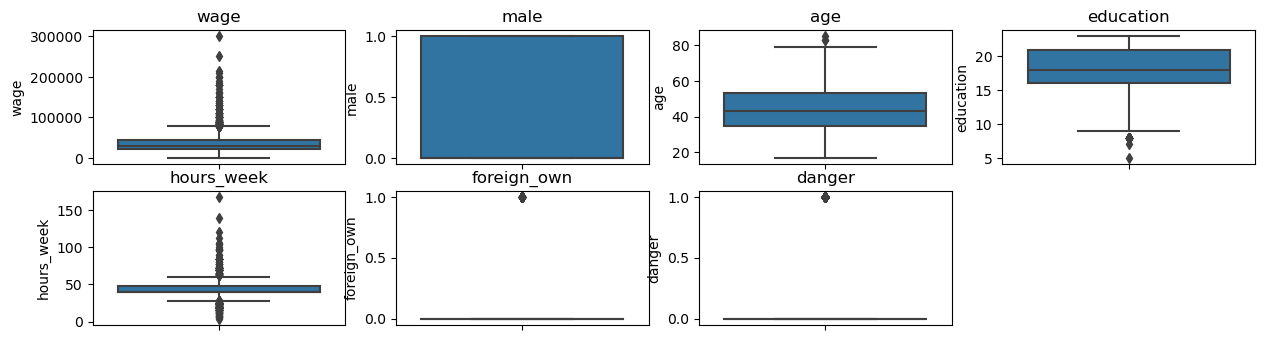

In [11]:
# Смотрим на выбросы
numeric_columns = df.columns.tolist()
plt.figure(figsize=(15, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.show()

Text(0.5, 1.0, 'Распределение заработной платы')

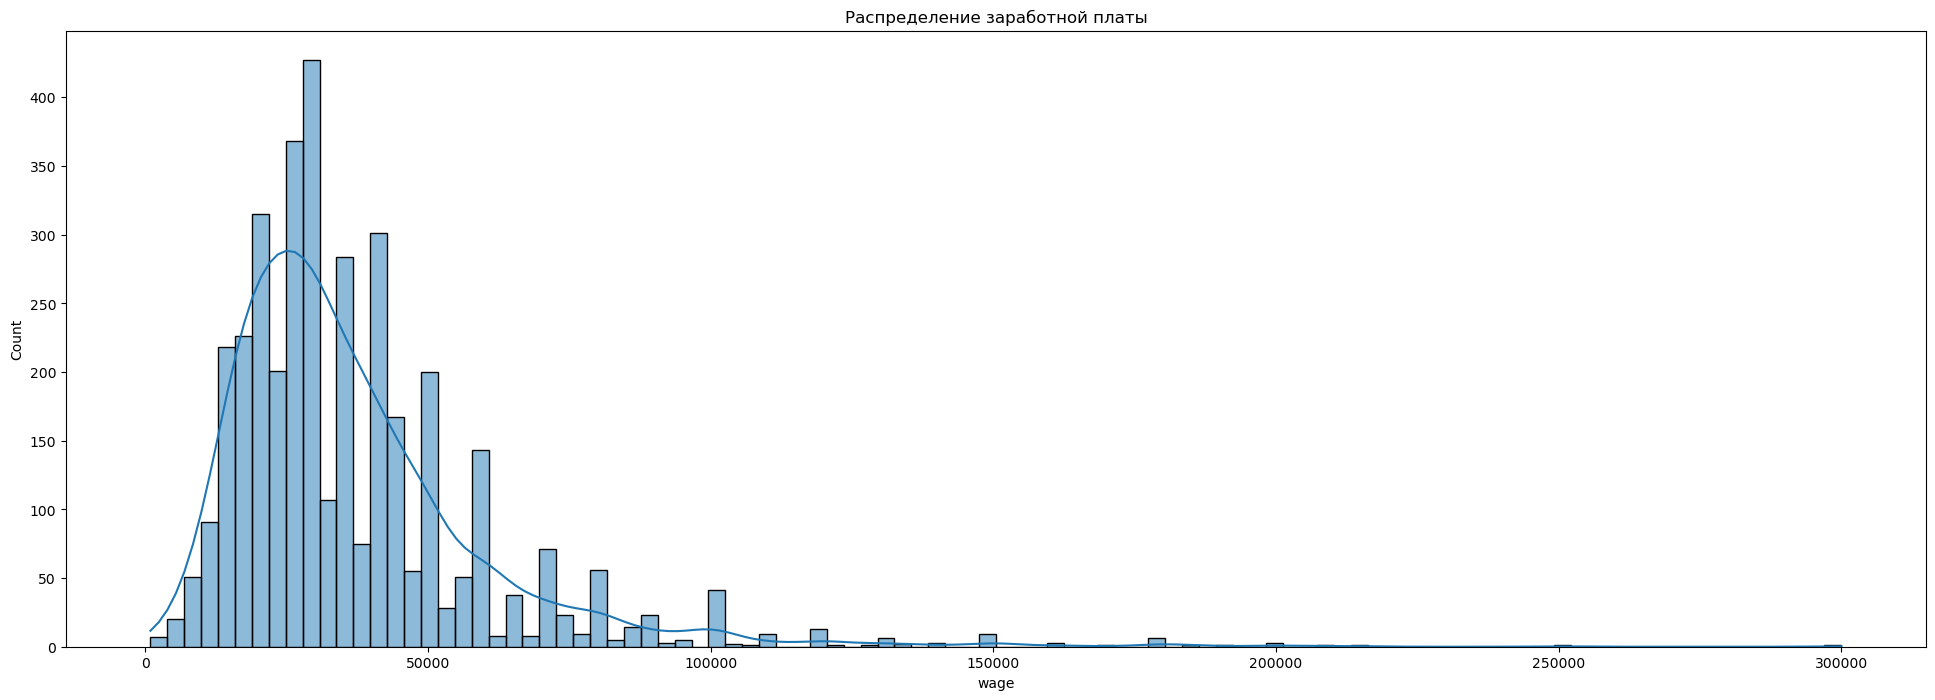

In [12]:
plt.figure(figsize=(24, 8))

# Смотрим распределение wage
sns.histplot(df['wage'], kde = True)
plt.title('Распределение заработной платы')

Text(0.5, 1.0, 'Распределение возраста')

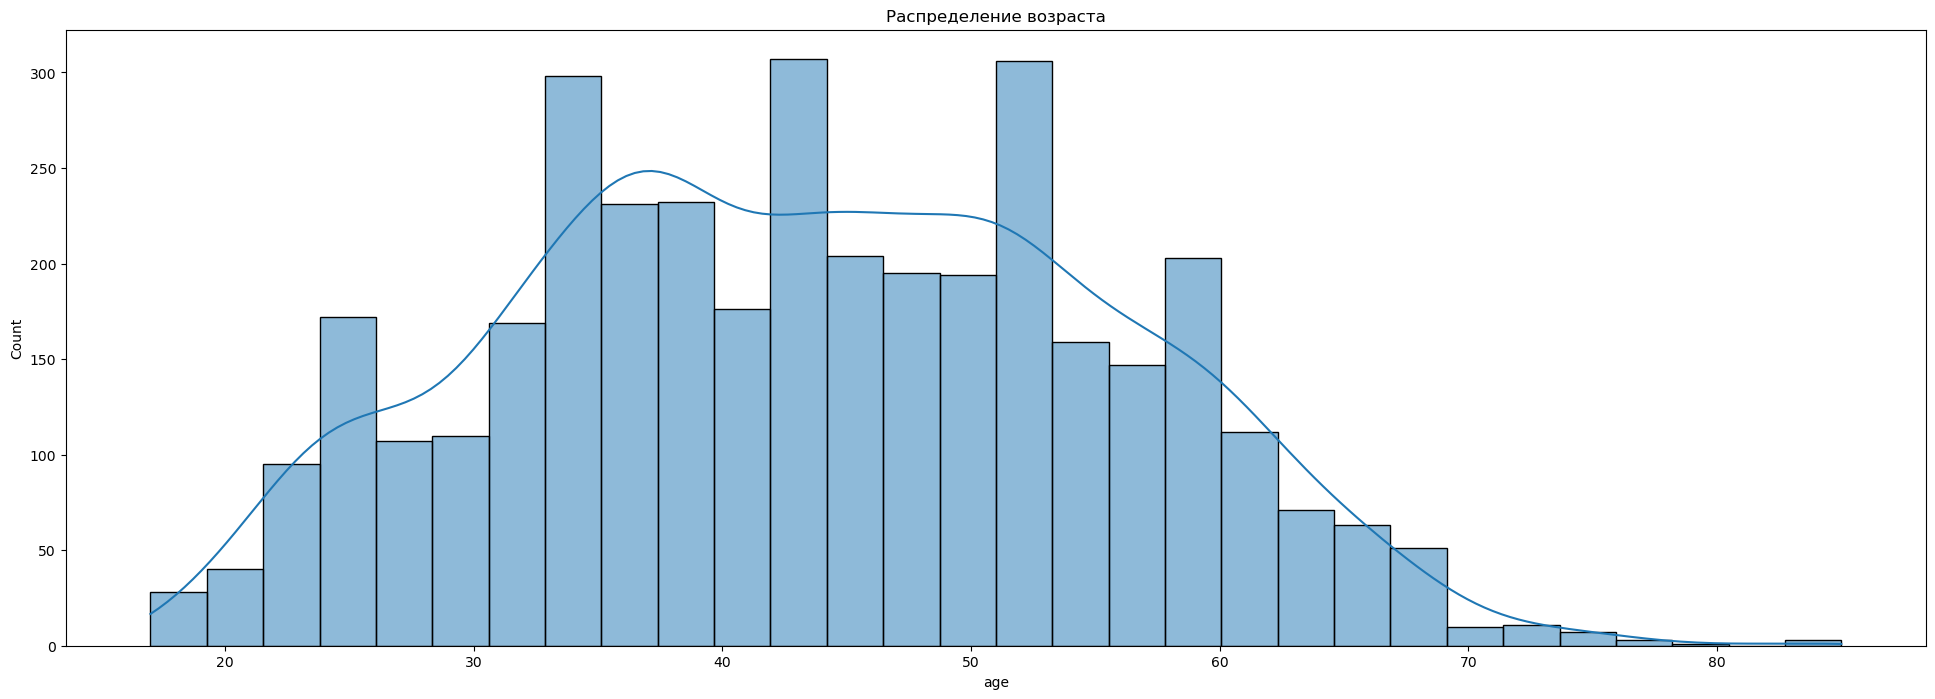

In [13]:
plt.figure(figsize=(24, 8))

# Смотрим распределение возраста
sns.histplot(df['age'], kde = True)
plt.title('Распределение возраста')

Нам нужно исключить выбросы

In [14]:
Q1 = df['wage'].quantile(0.25)
Q3 = df['wage'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Ограничение значений зп

df = df[(df['wage'] > lower_bound) & (df['wage'] < upper_bound)]

In [15]:
Q1 = df['hours_week'].quantile(0.25)
Q3 = df['hours_week'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['hours_week'] > lower_bound) & (df['hours_week'] < upper_bound)]

In [16]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['age'] > lower_bound) & (df['age'] < upper_bound)]

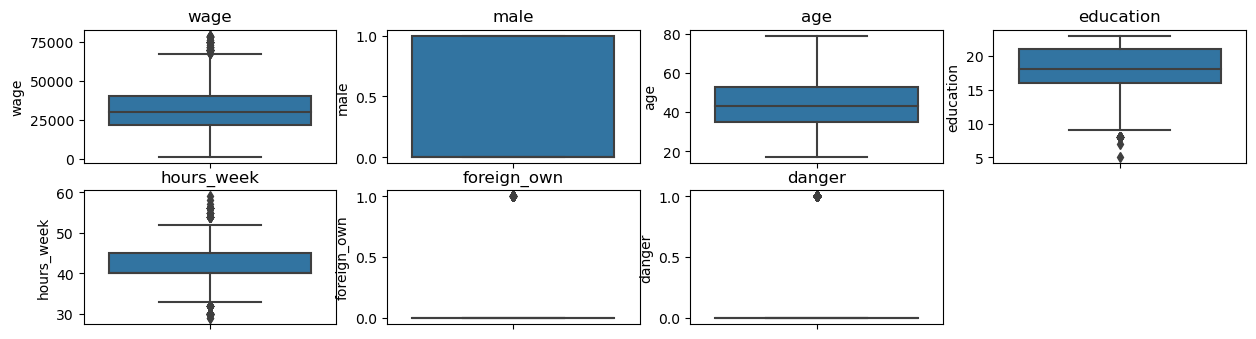

In [17]:
# Проверка на выбросы
numeric_columns = df.columns.tolist()
plt.figure(figsize=(15, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.show()

построим матрицу коррялиции

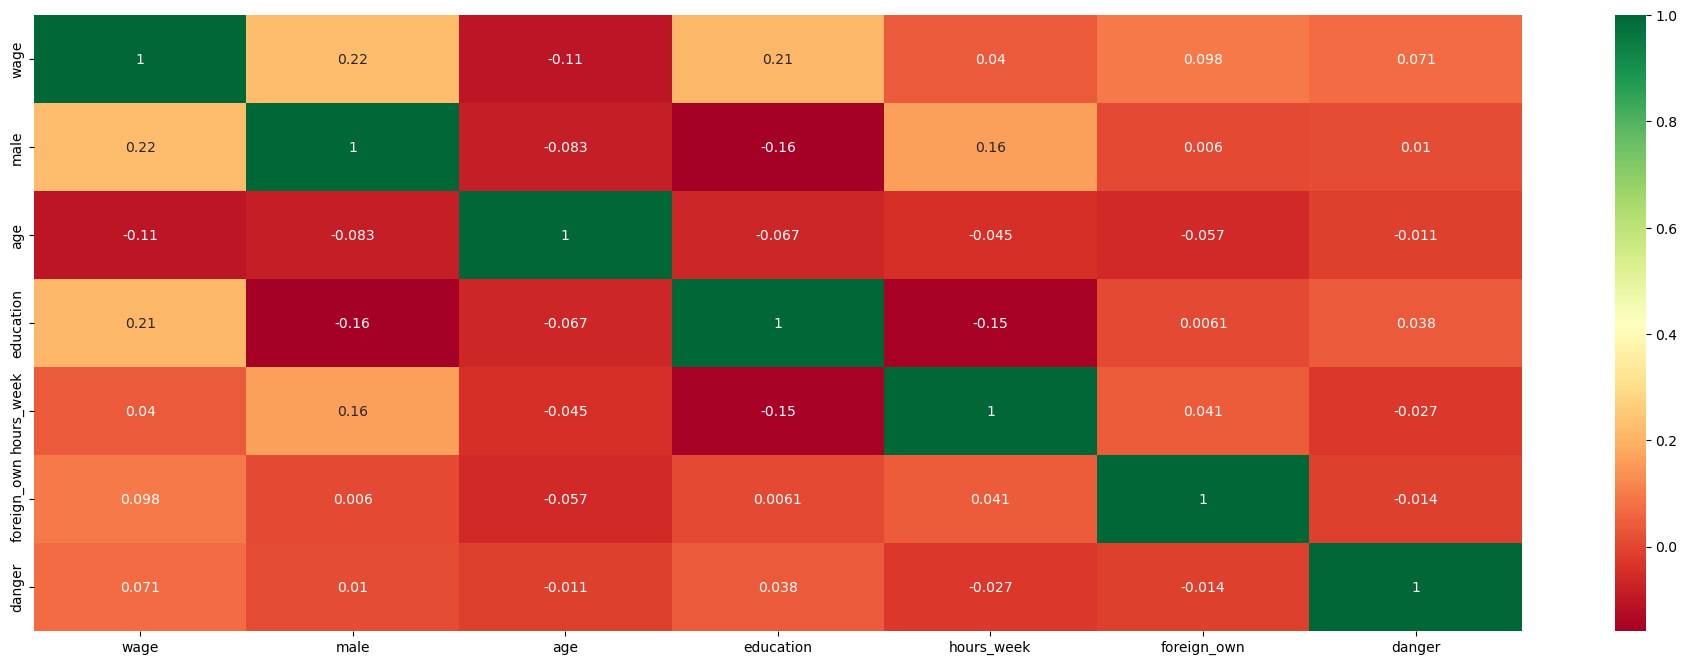

In [18]:
plt.figure(figsize=(24, 8))
sns.heatmap(df.corr(), annot=True, cmap = 'RdYlGn')
plt.show()

In [19]:
df.to_csv('data.csv')